In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

# Verbinde mit der SQLite-Datenbank
conn = sqlite3.connect('derstandard.db')

# Relevante Tabellen laden
articles_df = pd.read_sql_query("SELECT * FROM Articles", conn)
sentiment_df = pd.read_sql_query("SELECT * FROM Article_Sentiment", conn)
keywords_df = pd.read_sql_query("""
                                SELECT ak.articleID, k.keyword 
                                FROM Article_Keywords ak 
                                JOIN Keywords k ON ak.keywordID = k.keywordID
                                """, conn)

# Verbindung zur Datenbank schließen
conn.close()

# Definiere die relevanten Parteien, die in der Keywords Tabelle vorkommen können
parties = ['ÖVP', 'SPÖ', 'FPÖ', 'Grüne', 'NEOS']

# Filtere die Keywords-Tabelle, um nur die Einträge für die relevanten Parteien zu behalten
party_keywords_df = keywords_df[keywords_df['keyword'].isin(parties)]

# Gruppiere nach articleID, um sicherzustellen, dass nur Artikel mit genau einer Partei übrig bleiben
# Filtere alle Artikel heraus, die mehr als ein Partei-Keyword haben
party_counts_df = party_keywords_df.groupby('articleID').agg(
    party_count=('keyword', 'count'),
    Partei=('keyword', 'first')  
).reset_index()

# Filtere nur die Artikel, in denen genau eine Partei genannt wird
single_party_articles_df = party_counts_df[party_counts_df['party_count'] == 1]

# Artikel und Sentiment-Daten zusammenführen
df = pd.merge(articles_df, sentiment_df, on='articleID')
df = pd.merge(df, single_party_articles_df[['articleID', 'Partei']], on='articleID')

# Datumsspalte konvertieren
df['datetime'] = pd.to_datetime(df['datetime'])

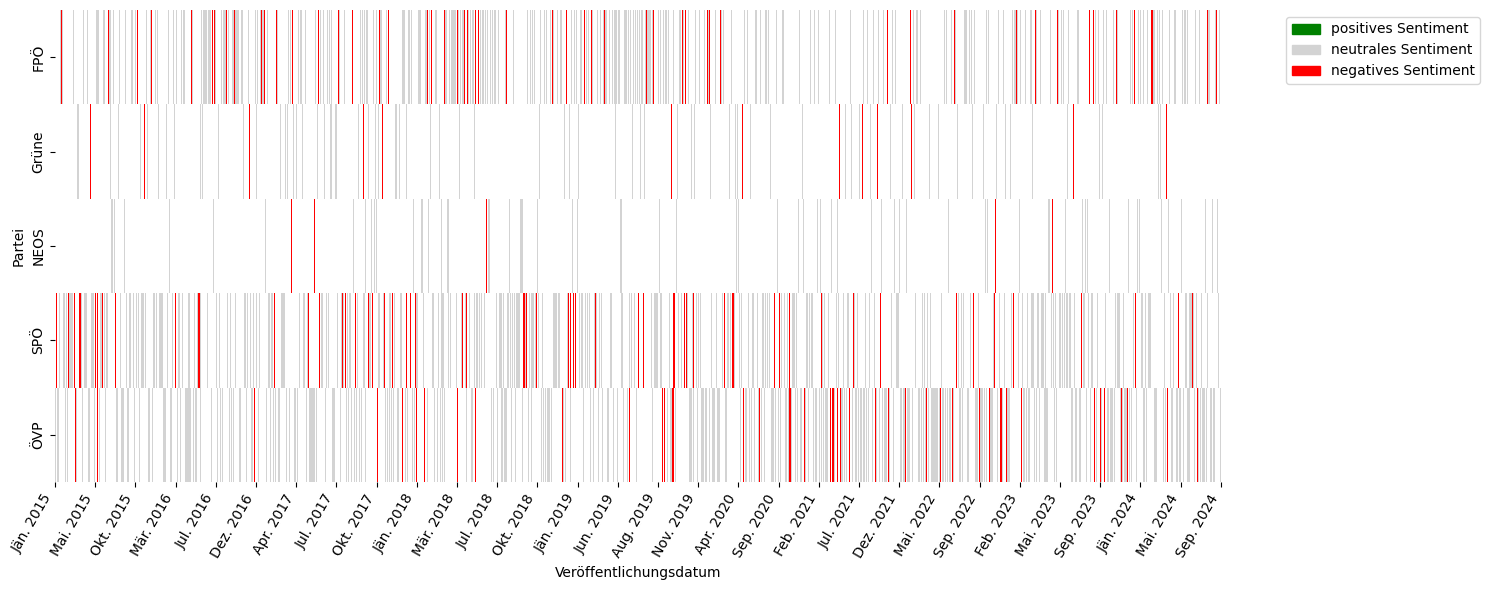

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# Gruppiere die Daten nach Veröffentlichungsdatum (Stunde) und Partei
grouped_df = df.groupby([pd.Grouper(key='datetime', freq='h'), 'Partei']).agg(
    n=('articleID', 'count'),
    mean_sentiment=('sentiment_value', 'mean')
).reset_index()

# Funktion zur Klassifizierung des Sentiments
def assign_sentiment_category(sum_sentiment):
    if sum_sentiment > 0.5:
        return 'positiv'
    elif sum_sentiment < -0.5:
        return 'negativ'
    else:
        return 'neutral'

# Sentiment-Kategorie zuweisen
grouped_df['sentiment'] = grouped_df['mean_sentiment'].apply(assign_sentiment_category)

# Sentiment-Kategorien in numerische Werte umwandeln
sentiment_mapping = {'negativ': -1, 'neutral': 0, 'positiv': 1}
grouped_df['sentiment_numeric'] = grouped_df['sentiment'].map(sentiment_mapping)

# Pivot-Tabelle erstellen (Partei vs. Veröffentlichungsdatum)
pivot_df = grouped_df.pivot(index='Partei', columns='datetime', values='mean_sentiment')

# Spalten (Daten) sortieren
pivot_df = pivot_df.sort_index(axis=1)

# Benutzerdefinierte Farbkarte erstellen
cmap = mcolors.ListedColormap(['red', 'lightgrey', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# datetime to str
formatted_dates = pivot_df.columns.strftime('%b. %Y')

# Plot erstellen
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linecolor='none')

# x-Achsen-Beschriftungen rotieren
plt.xticks(rotation=60, ha='right')

# Indizes für die xticks auswählen
num_years = pivot_df.columns.max().year - pivot_df.columns.min().year + 1
xticks_positions = np.linspace(0, len(formatted_dates) - 1, num=3 * num_years, dtype=int)
xticks_labels = [formatted_dates[i] for i in xticks_positions]

# xticks setzen
plt.gca().set_xticks(xticks_positions)
plt.gca().set_xticklabels(xticks_labels, rotation=60, ha='right')

# Achsenbeschriftungen 
plt.xlabel('Veröffentlichungsdatum')

# Legende für Sentiment erstellen
sentiment_handles = [
    mpatches.Patch(color='green', label='positives Sentiment'),
    mpatches.Patch(color='lightgrey', label='neutrales Sentiment'),
    mpatches.Patch(color='red', label='negatives Sentiment')
]

# Aktuelle Achsen holen
ax = plt.gca()

# Liste der Daten und Parteien holen
dates = pivot_df.columns 
parties = pivot_df.index.values

# Mapping von Partei zu y-Position erstellen
party_to_ypos = {party: i + 0.5 for i, party in enumerate(parties)} 

# Legende für Regierungskoalitionen erstellen
government_handles = []


# Beide Legenden kombinieren
handles = sentiment_handles + government_handles
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


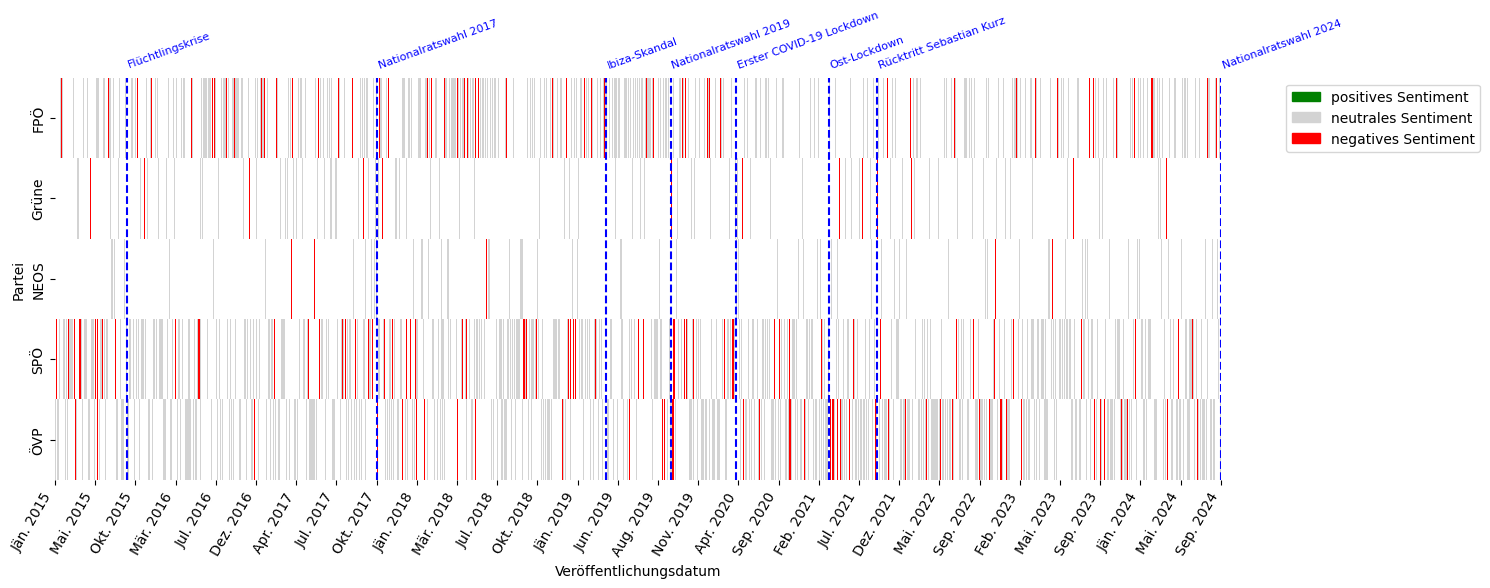

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# Gruppiere die Daten nach Veröffentlichungsdatum (Stunde) und Partei
grouped_df = df.groupby([pd.Grouper(key='datetime', freq='h'), 'Partei']).agg(
    n=('articleID', 'count'),
    mean_sentiment=('sentiment_value', 'mean')
).reset_index()

# Funktion zur Klassifizierung des Sentiments
def assign_sentiment_category(sum_sentiment):
    if sum_sentiment > 0.5:
        return 'positiv'
    elif sum_sentiment < -0.5:
        return 'negativ'
    else:
        return 'neutral'

# Sentiment-Kategorie zuweisen
grouped_df['sentiment'] = grouped_df['mean_sentiment'].apply(assign_sentiment_category)

# Sentiment-Kategorien in numerische Werte umwandeln
sentiment_mapping = {'negativ': -1, 'neutral': 0, 'positiv': 1}
grouped_df['sentiment_numeric'] = grouped_df['sentiment'].map(sentiment_mapping)

# Pivot-Tabelle erstellen (Partei vs. Veröffentlichungsdatum)
pivot_df = grouped_df.pivot(index='Partei', columns='datetime', values='mean_sentiment')

# Spalten (Daten) sortieren
pivot_df = pivot_df.sort_index(axis=1)

# Benutzerdefinierte Farbkarte erstellen
cmap = mcolors.ListedColormap(['red', 'lightgrey', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# datetime to str
formatted_dates = pivot_df.columns.strftime('%b. %Y')

# Plot erstellen
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linecolor='none')

# x-Achsen-Beschriftungen rotieren
plt.xticks(rotation=60, ha='right')

# Indizes für die xticks auswählen
num_years = pivot_df.columns.max().year - pivot_df.columns.min().year + 1
xticks_positions = np.linspace(0, len(formatted_dates) - 1, num=3 * num_years, dtype=int)
xticks_labels = [formatted_dates[i] for i in xticks_positions]

# xticks setzen
plt.gca().set_xticks(xticks_positions)
plt.gca().set_xticklabels(xticks_labels, rotation=60, ha='right')

# Achsenbeschriftungen 
plt.xlabel('Veröffentlichungsdatum')

# Legende für Sentiment erstellen
sentiment_handles = [
    mpatches.Patch(color='green', label='positives Sentiment'),
    mpatches.Patch(color='lightgrey', label='neutrales Sentiment'),
    mpatches.Patch(color='red', label='negatives Sentiment')
]

# Wichtige Ereignisse definieren
events = [
    ('2015-09-01', 'Flüchtlingskrise'),
    ('2017-10-15', 'Nationalratswahl 2017'),
    ('2019-05-17', 'Ibiza-Skandal'),
    ('2019-09-29', 'Nationalratswahl 2019'),
    ('2020-03-16', 'Erster COVID-19 Lockdown'),
    #('2020-11-17', 'Zweiter COVID-19 Lockdown'),
    #('2020-12-26', 'Dritter COVID-19 Lockdown'),
    ('2021-04-01', 'Ost-Lockdown'),
    #('2021-11-22', 'Vierter COVID-19 Lockdown'),
    #('2021-12-12', 'Ende des vierten Lockdowns'),
    ('2021-10-11', 'Rücktritt Sebastian Kurz'),
    ('2024-09-29', 'Nationalratswahl 2024')
]

# Aktuelle Achsen holen
ax = plt.gca()

# Liste der Daten und Parteien holen
dates = pivot_df.columns 
parties = pivot_df.index.values

# Mapping von Partei zu y-Position erstellen
party_to_ypos = {party: i + 0.5 for i, party in enumerate(parties)} 

# Legende für Regierungskoalitionen erstellen
government_handles = []

# Wichtige Ereignisse markieren
for date_str, event_name in events:
    date = pd.to_datetime(date_str)
    x_pos = np.searchsorted(dates, date)
    # Sicherstellen, dass die Position innerhalb des Bereichs liegt
    if 0 <= x_pos <= len(dates):
        ax.axvline(x=x_pos, color='blue', linestyle='--')
        ax.text(
            x=x_pos,
            y=-0.1,
            s=event_name,
            rotation=20,
            verticalalignment='bottom',
            fontsize=8,
            color='blue'
        )

# Beide Legenden kombinieren
handles = sentiment_handles + government_handles
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


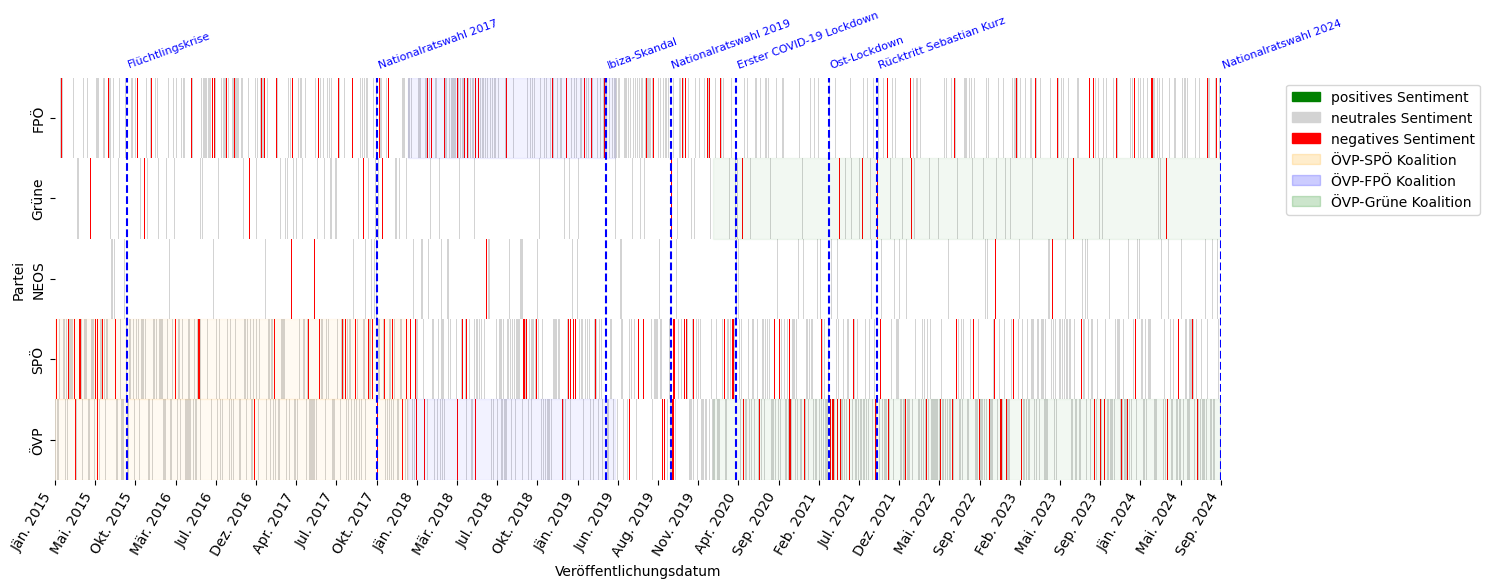

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# Gruppiere die Daten nach Veröffentlichungsdatum (Stunde) und Partei
grouped_df = df.groupby([pd.Grouper(key='datetime', freq='h'), 'Partei']).agg(
    n=('articleID', 'count'),
    mean_sentiment=('sentiment_value', 'mean')
).reset_index()

# Funktion zur Klassifizierung des Sentiments
def assign_sentiment_category(sum_sentiment):
    if sum_sentiment > 0.5:
        return 'positiv'
    elif sum_sentiment < -0.5:
        return 'negativ'
    else:
        return 'neutral'

# Sentiment-Kategorie zuweisen
grouped_df['sentiment'] = grouped_df['mean_sentiment'].apply(assign_sentiment_category)

# Sentiment-Kategorien in numerische Werte umwandeln
sentiment_mapping = {'negativ': -1, 'neutral': 0, 'positiv': 1}
grouped_df['sentiment_numeric'] = grouped_df['sentiment'].map(sentiment_mapping)

# Pivot-Tabelle erstellen (Partei vs. Veröffentlichungsdatum)
pivot_df = grouped_df.pivot(index='Partei', columns='datetime', values='mean_sentiment')

# Spalten (Daten) sortieren
pivot_df = pivot_df.sort_index(axis=1)

# Benutzerdefinierte Farbkarte erstellen
cmap = mcolors.ListedColormap(['red', 'lightgrey', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# datetime to str
formatted_dates = pivot_df.columns.strftime('%b. %Y')

# Plot erstellen
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linecolor='none')

# x-Achsen-Beschriftungen rotieren
plt.xticks(rotation=60, ha='right')

# Indizes für die xticks auswählen
num_years = pivot_df.columns.max().year - pivot_df.columns.min().year + 1
xticks_positions = np.linspace(0, len(formatted_dates) - 1, num=3 * num_years, dtype=int)
xticks_labels = [formatted_dates[i] for i in xticks_positions]

# xticks setzen
plt.gca().set_xticks(xticks_positions)
plt.gca().set_xticklabels(xticks_labels, rotation=60, ha='right')

# Achsenbeschriftung
plt.xlabel('Veröffentlichungsdatum')

# Legende für Sentiment erstellen
sentiment_handles = [
    mpatches.Patch(color='green', label='positives Sentiment'),
    mpatches.Patch(color='lightgrey', label='neutrales Sentiment'),
    mpatches.Patch(color='red', label='negatives Sentiment')
]

# Regierungskoalitionen mit unterschiedlichen Farben
governments = [
    {
        'name': 'ÖVP-SPÖ Koalition',
        'parties': ['ÖVP', 'SPÖ'],
        'start': '2013-12-16',
        'end': '2017-12-18',
        'color': 'orange'
    },
    {
        'name': 'ÖVP-FPÖ Koalition',
        'parties': ['ÖVP', 'FPÖ'],
        'start': '2017-12-18',
        'end': '2019-05-28',
        'color': 'blue'
    },
    {
        'name': 'ÖVP-Grüne Koalition',
        'parties': ['ÖVP', 'Grüne'],
        'start': '2020-01-07',
        'end': '2025-09-01',
        'color': 'green'
    }
]

# Wichtige Ereignisse definieren
events = [
    ('2015-09-01', 'Flüchtlingskrise'),
    ('2017-10-15', 'Nationalratswahl 2017'),
    ('2019-05-17', 'Ibiza-Skandal'),
    ('2019-09-29', 'Nationalratswahl 2019'),
    ('2020-03-16', 'Erster COVID-19 Lockdown'),
    #('2020-11-17', 'Zweiter COVID-19 Lockdown'),
    #('2020-12-26', 'Dritter COVID-19 Lockdown'),
    ('2021-04-01', 'Ost-Lockdown'),
    #('2021-11-22', 'Vierter COVID-19 Lockdown'),
    #('2021-12-12', 'Ende des vierten Lockdowns'),
    ('2021-10-11', 'Rücktritt Sebastian Kurz'),
    ('2024-09-29', 'Nationalratswahl 2024')
]

# Aktuelle Achsen holen
ax = plt.gca()

# Liste der Daten und Parteien holen
dates = pivot_df.columns 
parties = pivot_df.index.values

# Mapping von Partei zu y-Position erstellen
party_to_ypos = {party: i + 0.5 for i, party in enumerate(parties)} 

# Legende für Regierungskoalitionen erstellen
government_handles = []

# Regierungszeiten schattieren
for gov in governments:
    gov_name = gov['name']
    gov_parties = gov['parties']
    start_date = pd.to_datetime(gov['start'])
    end_date = pd.to_datetime(gov['end'])
    color = gov['color']
    
    # Für die Legende (nur einmal pro Regierung)
    government_handles.append(mpatches.Patch(color=color, alpha=0.2, label=gov_name))
    
    # x-Positionen finden
    start_x = np.searchsorted(dates, start_date)
    end_x = np.searchsorted(dates, end_date)
    # Sicherstellen, dass die Positionen innerhalb des Bereichs liegen
    start_x = max(start_x, 0)
    end_x = min(end_x, len(dates))
    
    for party in gov_parties:
        if party in party_to_ypos:
            y_pos = party_to_ypos[party]
            # Rechteck zeichnen
            rect = mpatches.Rectangle(
                (start_x, y_pos - 0.5),  # -0.5 um die gesamte Zelle abzudecken
                width=end_x - start_x,
                height=1,
                color=color,
                alpha=0.05
            )
            ax.add_patch(rect)

# Wichtige Ereignisse markieren
for date_str, event_name in events:
    date = pd.to_datetime(date_str)
    x_pos = np.searchsorted(dates, date)
    # Sicherstellen, dass die Position innerhalb des Bereichs liegt
    if 0 <= x_pos <= len(dates):
        ax.axvline(x=x_pos, color='blue', linestyle='--')
        ax.text(
            x=x_pos,
            y=-0.1,
            s=event_name,
            rotation=20,
            verticalalignment='bottom',
            fontsize=8,
            color='blue'
        )

# Beide Legenden kombinieren
handles = sentiment_handles + government_handles
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Erweiterungen
- User-Kommentare?
- Emotionen?
- Ambivalente Artikel? "Wirklich neutrale" Artikel, oder unterschiedliche Sentiments je nach Paragraph.

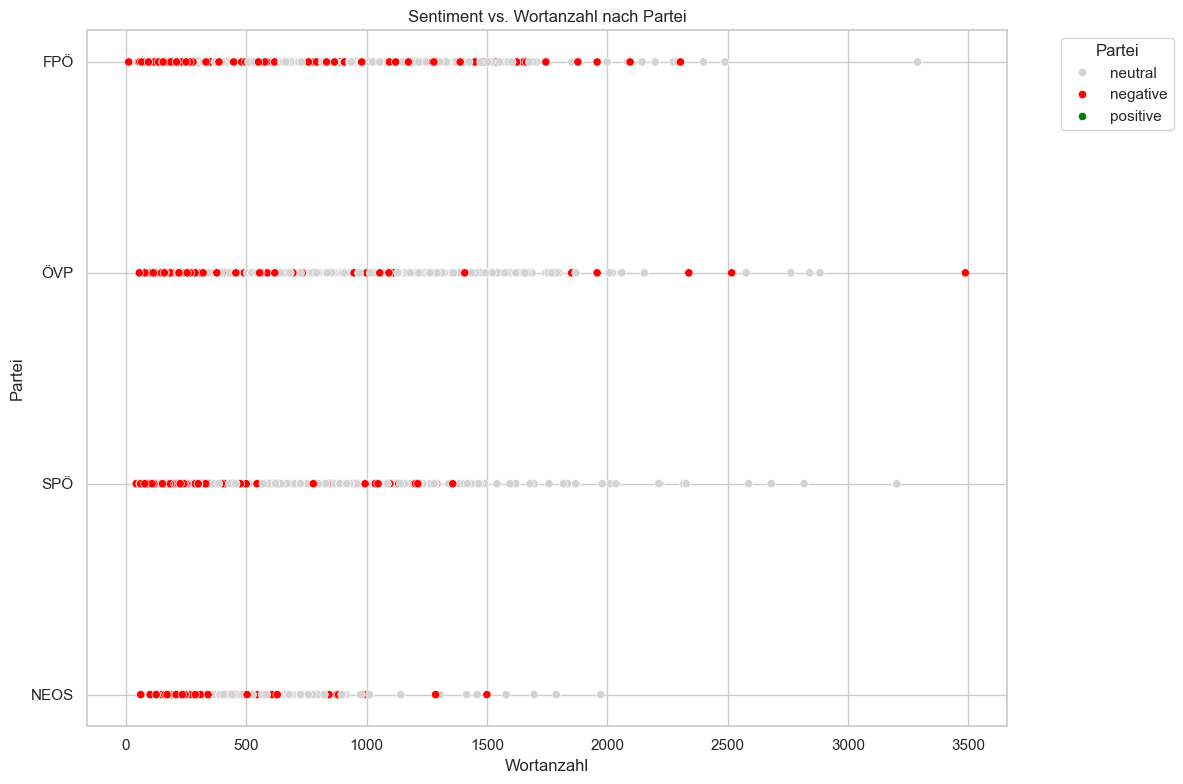

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_articles_with_one_keyword(conn):
    query = '''
    SELECT
        a.articleID,
        k.keyword,
        af.sentence_count,
        af.word_count,
        af.avg_word_length,
        af.token_count,
        asent.sentiment_category
    FROM Articles a
    JOIN Article_Keywords ak ON a.articleID = ak.articleID
    JOIN Keywords k ON ak.keywordID = k.keywordID
    JOIN Article_Features af ON a.articleID = af.articleID
    JOIN Article_Sentiment asent ON a.articleID = asent.articleID
    WHERE a.articleID IN (
        SELECT articleID
        FROM Article_Keywords
        GROUP BY articleID
        HAVING COUNT(*) = 1
    ) AND asent.sentiment_value != 0
    AND k.keyword NOT IN ('Grüne', 'KPÖ')
    '''
    df = pd.read_sql_query(query, conn)
    return df

def main():
    # Verbindung zur Datenbank herstellen
    conn = sqlite3.connect('derstandard.db')
    
    # Daten abrufen mit Fehlerbehandlung
    try:
        df = get_articles_with_one_keyword(conn)
    except Exception as e:
        print(f"Fehler beim Abrufen der Daten: {e}")
        conn.close()
        return
    
    # Berechnung des Komplexitätsmaßes
    try:
        df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
        df['complexity'] = df['avg_sentence_length'] * df['avg_word_length']
    except Exception as e:
        print(f"Fehler bei der Berechnung der Textkomplexität: {e}")
        conn.close()
        return
    
    
    # Visualisierung
    try:
        # Definieren der Farben für die Sentiment-Kategorien
        sentiment_colors = {
            'positive': '#008000',  # Grün
            'negative': '#FF0000',  # Rot
            'neutral': '#D3D3D3'    # Hellgrau
        }

        plt.figure(figsize=(12, 8))
        scatter = sns.scatterplot(
            data=df,
            x='word_count',
            y='keyword',
            hue='sentiment_category',
            palette=sentiment_colors,
            
        )
        plt.title('Sentiment vs. Wortanzahl nach Partei')
        plt.xlabel("Wortanzahl")
        plt.ylabel("Partei")
        plt.legend(title='Partei', bbox_to_anchor=(1.05, 1), loc=2)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Fehler bei der Visualisierung: {e}")
    
    # Verbindung schließen
    conn.close()

if __name__ == "__main__":
    main()


c:\Users\sdola\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\sdola\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


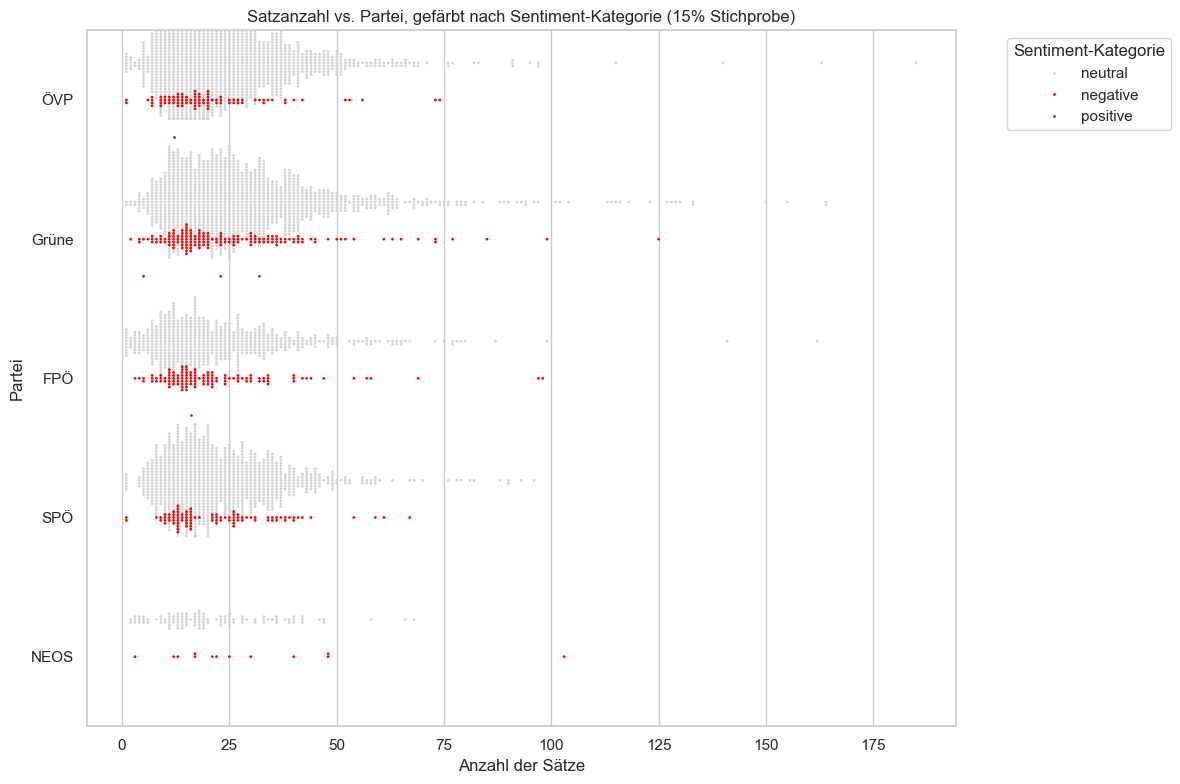

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_articles_with_one_keyword(conn):
    query = '''
    SELECT
        a.articleID,
        k.keyword,
        af.sentence_count,
        af.word_count,
        af.avg_word_length,
        af.token_count,
        asent.sentiment_category
    FROM Articles a
    JOIN Article_Keywords ak ON a.articleID = ak.articleID
    JOIN Keywords k ON ak.keywordID = k.keywordID
    JOIN Article_Features af ON a.articleID = af.articleID
    JOIN Article_Sentiment asent ON a.articleID = asent.articleID
    WHERE a.articleID IN (
        SELECT articleID
        FROM Article_Keywords
        GROUP BY articleID
        HAVING COUNT(*) = 1
    ) AND k.keyword NOT IN ('KPÖ')
    '''
    df = pd.read_sql_query(query, conn)
    return df

def main():
    # Verbindung zur Datenbank herstellen
    conn = sqlite3.connect('derstandard.db')
    
    # Daten abrufen mit Fehlerbehandlung
    try:
        df = get_articles_with_one_keyword(conn)
    except Exception as e:
        print(f"Fehler beim Abrufen der Daten: {e}")
        conn.close()
        return
    
    # Berechnung des Komplexitätsmaßes
    try:
        df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
        df['complexity'] = df['avg_sentence_length'] * df['avg_word_length']
    except Exception as e:
        print(f"Fehler bei der Berechnung der Textkomplexität: {e}")
        conn.close()
        return
    
    # Umgang mit fehlenden Werten
    df.dropna(subset=['sentence_count', 'keyword', 'sentiment_category'], inplace=True)
    
    # **Datenmenge auf 15% reduzieren**
    df_sampled = df.sample(frac=0.15, random_state=42).reset_index(drop=True)
    
    # Visualisierung mit Swarmplot und angepassten Farben
    try:
        plt.figure(figsize=(12, 8))
        
        # Definieren der Farben für die Sentiment-Kategorien
        sentiment_colors = {
            'positive': '#008000',  # Grün
            'negative': '#FF0000',  # Rot
            'neutral': '#D3D3D3'    # Hellgrau
        }
        
        # Markergröße reduzieren
        marker_size = 2
        
        # Swarmplot erstellen
        swarm = sns.swarmplot(
            data=df_sampled,
            x='sentence_count',
            y='keyword',
            hue='sentiment_category',
            palette=sentiment_colors,
            dodge=True,
            size=marker_size
        )
        
        plt.title('Satzanzahl vs. Partei, gefärbt nach Sentiment-Kategorie (15% Stichprobe)')
        plt.xlabel('Anzahl der Sätze')
        plt.ylabel('Partei')
        plt.legend(title='Sentiment-Kategorie', bbox_to_anchor=(1.05, 1), loc=2)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Fehler bei der Visualisierung: {e}")
    
    # Verbindung schließen
    conn.close()

if __name__ == "__main__":
    main()


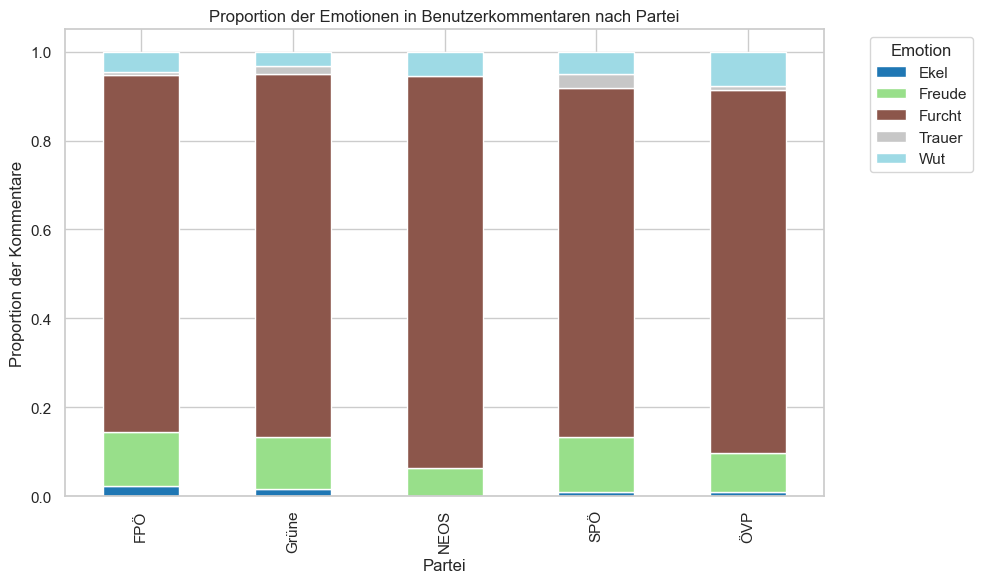

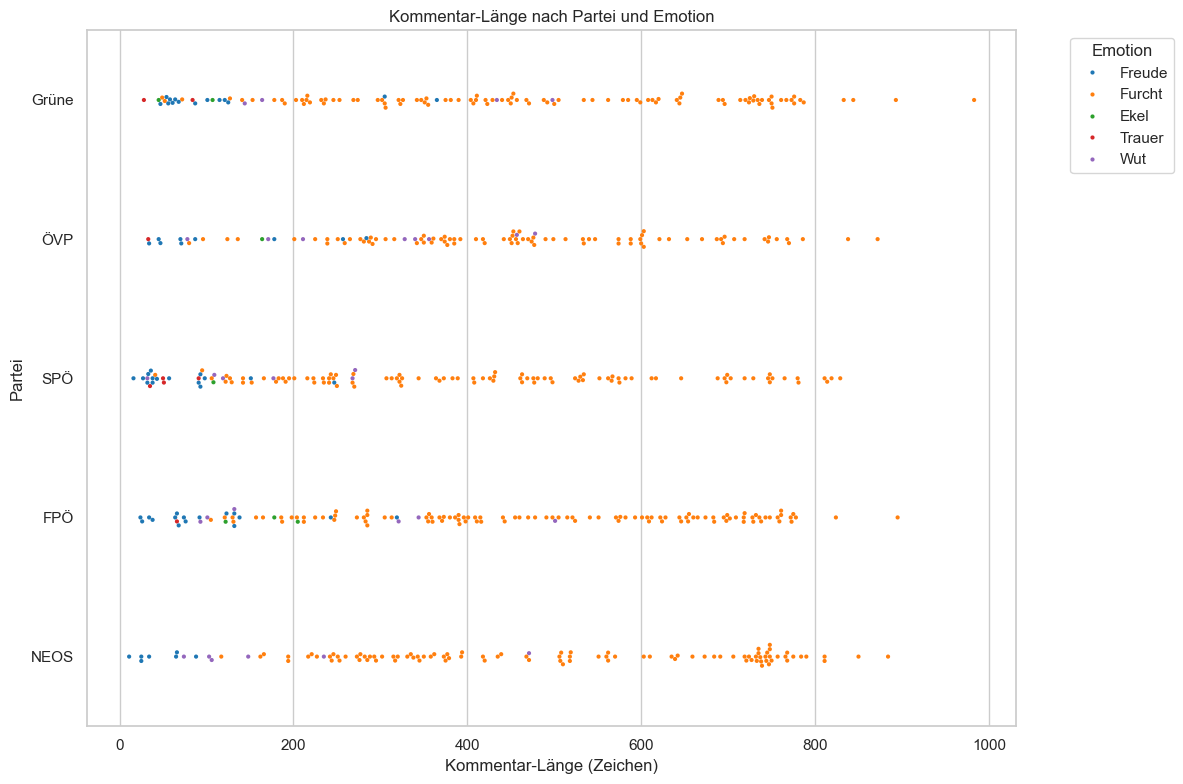

In [48]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_comment_emotions_by_party(conn):
    parties = ['ÖVP', 'SPÖ', 'FPÖ', 'Grüne', 'NEOS', 'KPÖ']
    placeholders = ','.join('?' * len(parties))
    query = f'''
    WITH single_party_articles AS (
        SELECT ak.articleID, k.keyword AS party
        FROM Article_Keywords ak
        JOIN Keywords k ON ak.keywordID = k.keywordID
        WHERE k.keyword IN ({placeholders})
        GROUP BY ak.articleID
        HAVING COUNT(*) = 1
    )
    SELECT
        c.commentID,
        c.articleID,
        spa.party,
        e.emotion
    FROM comments c
    JOIN Article_comment_emotions ace ON c.commentID = ace.commentID
    JOIN Emotions e ON ace.emotionID = e.emotionID
    JOIN single_party_articles spa ON c.articleID = spa.articleID
    WHERE e.emotion != 'keine Emotion'
    '''
    df = pd.read_sql_query(query, conn, params=parties)
    return df

def prepare_emotion_data(df):
    # Anzahl der Kommentare pro Emotion und Partei berechnen
    emotion_counts = df.groupby(['party', 'emotion']).size().reset_index(name='counts')
    # Daten pivotieren, um Parteien als Zeilen und Emotionen als Spalten zu haben
    emotion_pivot = emotion_counts.pivot(index='party', columns='emotion', values='counts').fillna(0)
    return emotion_pivot


def plot_emotion_distribution(emotion_pivot):
    # Proportionen berechnen, um die Verhältnisse darzustellen
    party_totals = emotion_pivot.sum(axis=1)
    emotion_proportions = emotion_pivot.div(party_totals, axis=0)
    
    # Gestapeltes Balkendiagramm erstellen
    emotion_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

    plt.title('Proportion der Emotionen in Benutzerkommentaren nach Partei')
    plt.xlabel('Partei')
    plt.ylabel('Proportion der Kommentare')
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def get_comment_emotions_with_length(conn):
    parties = ['ÖVP', 'SPÖ', 'FPÖ', 'Grüne', 'NEOS', 'KPÖ']
    placeholders = ','.join('?' * len(parties))
    query = f'''
    WITH single_party_articles AS (
        SELECT ak.articleID, k.keyword AS party
        FROM Article_Keywords ak
        JOIN Keywords k ON ak.keywordID = k.keywordID
        WHERE k.keyword IN ({placeholders})
        GROUP BY ak.articleID
        HAVING COUNT(*) = 1
    )
    SELECT
        c.commentID,
        c.articleID,
        spa.party,
        e.emotion,
        LENGTH(c.comment || c.comment_header) AS comment_length
    FROM comments c
    JOIN Article_comment_emotions ace ON c.commentID = ace.commentID
    JOIN Emotions e ON ace.emotionID = e.emotionID
    JOIN single_party_articles spa ON c.articleID = spa.articleID
    WHERE e.emotion != 'keine Emotion'
    '''
    df = pd.read_sql_query(query, conn, params=parties)
    return df




def plot_emotion_swarm(df):
    plt.figure(figsize=(12, 8))
    sns.swarmplot(
        x='comment_length',
        y='party',
        hue='emotion',
        data=df,
        palette='tab10',
        size=3
    )
    plt.title('Kommentar-Länge nach Partei und Emotion')
    plt.xlabel('Kommentar-Länge (Zeichen)')
    plt.ylabel('Partei')
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def main():
    # Verbindung zur Datenbank herstellen
    conn = sqlite3.connect('derstandard.db')
    try:
        df = get_comment_emotions_by_party(conn)
        emotion_pivot = prepare_emotion_data(df)
        plot_emotion_distribution(emotion_pivot)
        
        df_length = get_comment_emotions_with_length(conn)
        plot_emotion_swarm(df_length)
    except Exception as e:
        print(f"Fehler beim Abrufen oder Verarbeiten der Daten: {e}")
    finally:
        conn.close()

if __name__ == '__main__':
    main()



# Wichtige Hinweise
- Keyword "Grüne" wird trotz "Politik-Kontext" immer wieder falsch erkannt => sehr eingeschränkte Aussagekraft 

- Kommentare scrapen hat für 2023/2024 fast garnicht funktioniert (blocker vom Standard?)
- Analyse der Kommentare:
    - Sentiment ermitteln und im Zusammenhang mit Followers, upvotes, downvotes, emotion-analyse das Sentiment gewichten(?)
    - Nutzerbasierte Analyse => Viel-PosterInnen
    - Hatespeech(?) - eventuell werden die Ergebnisse nicht zufriedenstellend sein, da häufig Forenmoderation vorhanden ist.
    - Modell für Emotion-Analyse scheint sehr unterschiedliche Ergebnisse (je nach Kommentarlänge) zu liefern => wo ist die accuracy am größten??
    

